In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from utils.plot_utils import *

warnings.filterwarnings('ignore')

## Load geometric information

In [2]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.interpolate import interpn, RectBivariateSpline
from scipy.io import loadmat

with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    ap = h5f['ensemble/links/m_ij/AP_coordinates'][0, :][()]
    dv = h5f['ensemble/links/m_ij/DV_coordinates'][:, 0][()]
    dAP = ap[1]-ap[0]
    dDV = dv[1]-dv[0]
    YX = np.stack(np.meshgrid(dv, ap, indexing='ij'), axis=-1)

geo_dir = '../flydrive.synology.me/Public/dynamic_atlas/embryo_geometry'
geometry = loadmat(os.path.join(geo_dir, 'embryo_rectPIVscale_fundamentalForms.mat'), simplify_cells=True)
#Convert to microns
X0g = geometry['X0'][0, :] * 0.2619 / 0.4
Y0g = geometry['Y0'][:, 0] * 0.2619 / 0.4
print('Metric Extent: %.3f %.3f %.3f %.3f' % (
    X0g.min(), X0g.max(), Y0g.min(), Y0g.max()))
print('Data Extent: %.3f %.3f %.3f %.3f' % (
    ap.min(), ap.max(), dv.min(), dv.max()))

Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
print('Loaded Christoffel symbols from Public')

def embryo_pad(x0, pad_width=20, dv_pad='wrap', ap_pad='edge', **kwargs):
    x = x0.reshape([-1, *x0.shape[-2:]])
    x = np.pad(x, ((0, 0), (pad_width, pad_width), (0, 0)), mode=dv_pad)
    x = np.pad(x,  ((0, 0), (0, 0), (pad_width, pad_width)), mode=ap_pad)
    x = x.reshape([*x0.shape[:-2], *x.shape[-2:]])
    '''
    Since we reflected along the x axis, we have to 
    adjust vector/tensor components in the reflected region
    '''
    if ap_pad in ['reflect', 'symmetric']:
        if len(x.shape) == 3: #Vector
            x[1, :,  :pad_width] *= -1
            x[1, :, -pad_width:] *= -1

        elif len(x.shape) == 4: #Tensor
            x[0, 1, :,  :pad_width] *= -1
            x[0, 1, :, -pad_width:] *= -1
            x[1, 0, :,  :pad_width] *= -1
            x[1, 0, :, -pad_width:] *= -1
    return x

def gradient(x0, dDV=2.7, dAP=2.7, sigma=5, **pad_kwargs):
    pad_width=4*sigma
    x = embryo_pad(x0, pad_width=pad_width, **pad_kwargs)

    dY_x = gaussian_filter1d(x, axis=-2, sigma=sigma, order=1, mode='nearest') / dDV
    dX_x = gaussian_filter1d(x, axis=-1, sigma=sigma, order=1, mode='nearest') / dAP
    return np.stack([
        dY_x[..., pad_width:-pad_width, pad_width:-pad_width],
        dX_x[..., pad_width:-pad_width, pad_width:-pad_width]
    ], axis=-1)

def covariant_gradient(x0, **diff_args):
    grad_x = gradient(x0, **diff_args)

    if len(x0.shape) == 3: #Vector
        grad_x += np.einsum('yxijk,kyx->iyxj', Gijk, x0)
        #grad_x -= np.einsum('yxkij,kyx->iyxj', Gijk, x0)
    elif len(x0.shape) == 4: #Tensor
        grad_x += np.einsum('yxikl,ljyx->ijyxk', Gijk, x0) + \
                  np.einsum('yxjkl,ilyx->ijyxk', Gijk, x0)
        #grad_x -= np.einsum('yxlik,ljyx->ijyxk', Gijk, x0) + \
        #          np.einsum('yxljk,ilyx->ijyxk', Gijk, x0)
    return grad_x

KeyError: 'Unable to open object (component not found)'

# Learning closed loop with just myosin

## Load data

In [5]:
from utils.library.composite_library import fill_group_info, collect_library, take_time_derivatives, decompose_library
from utils.library.extra_functions import *
        
libraries = [
    ('m_ij', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('v', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', None), #Not focused on flow dynamics
    ('c', 'Public/WT/ECad-GFP', 'scalar_library', None), #Not focused on cadherin dynamics, just include it as a source
]

    
extra_functions = [
    lambda data: material_derivative_terms(data, keys=['m_ij']),
    #lambda data: tensor_to_scalar(data, ['E', 'm_ij']),
    lambda data: active_strain_decomposition(data, key='m_ij'),
    lambda data: add_static_sources(data, couple='m_ij'),
    #lambda data: add_dorsal_source(data, couple='m_ij', key='ELLIPSE_A=0.5_B=0.25'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_active', 'E_passive', 'E_full']),
    lambda data: remove_terms(data, max_space_order=1),
    lambda data: multiply_tensor_by_scalar(data, None, ['c']),
]


with h5py.File(os.path.join(libraries[0][1], 'derivative_library.h5'), 'r') as h5f:
    embryoIDs = list(h5f.keys())

with h5py.File('Public/myosin_dynamics_fitting.h5', 'w') as data:
    with tqdm(total=len(embryoIDs)) as pbar:
        pbar.set_description('Collecting embryo data')
        for embryoID in embryoIDs:
            pbar.set_postfix(embryoID=embryoID)
            group, feature_names = fill_group_info(data, embryoID, libraries)
            collect_library(group, 
                            libraries, 
                            feature_names, 
                            extra_functions=extra_functions)
            take_time_derivatives(group, libraries, window_length=9)
            decompose_library(group, libraries)
            
            pbar.update()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Learn Myosin model

  0%|          | 0/13 [00:00<?, ?it/s]

D_t m_ij = 0.053 Static_DV Tr(m_ij) + -0.038 c Static_DV Tr(m_ij) + 0.077 c m_ij + 0.284 c m_ij Tr(E_full) + -0.519 c m_ij Tr(m_ij) + -0.086 m_ij + 0.516 m_ij Tr(E_full) + 0.699 m_ij Tr(m_ij)
PCA Component R2=-5.29245	MSE=0.572259


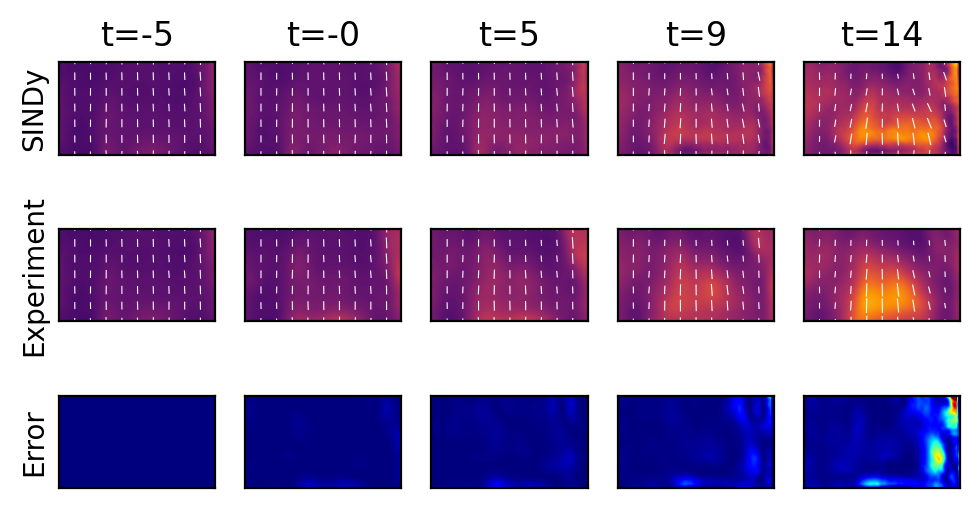

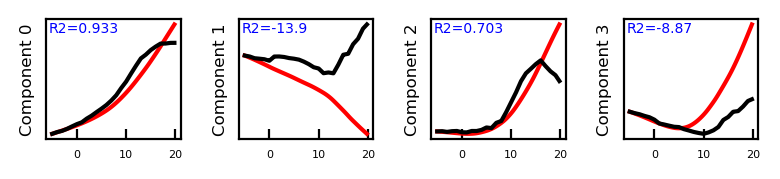

In [17]:
import pickle as pk
from utils.modeling.sindy_utils import *
from utils.modeling.evaluate_utils import *

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['figure.dpi'] = 200
np.set_printoptions(precision=3, suppress=True)


path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP'
key = 'm_ij'

model = pk.load(open(os.path.join(path, 'decomposition_models', 'tensor_SVDPipeline_PMG_CF.pkl'), 'rb'))

evr = model['svd'].explained_variance_ratio_
keep=np.cumsum(evr) <= 0.95
scaled_evr = evr / np.min(evr[keep]) * keep

info = dict(
    key=key,
    tmin=-5, tmax=10,
    threshold=1e-2,
    alpha=1e1,
    n_candidates_to_drop=0,
    n_models=10,
    subset_fraction=0.1,
    overleaf_only=False,
    component_weight=scaled_evr,
    collect_function=collect_raw_data,
)

with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    sindy = fit_sindy_model(h5f, **info)

    #Evaluate model
    data = h5f['ensemble']
    tmin, tmax = -5, 20    
    tmin = max(tmin, int(np.min(data['fields'][key].attrs['t'])))
    tmax = min(tmax, int(np.max(data['fields'][key].attrs['t'])))
    pred, interp, times = sindy_predict(data, key, sindy, tmin=tmin, tmax=tmax)
    sindy_predictions_plot(pred, interp, times)
    decomposed_predictions_plot(pred, interp, times, model, keep)


# Learning closed loop with myosin and cadherin

## Load data

In [239]:
from utils.translation_utils import *
from utils.decomposition_utils import *
from library_generation.extra_functions import *
        
libraries = [
    #('c', 'Public/WT/ECad-GFP', 'scalar_library', 'cyt_SVDPipeline_PMG_CF.pkl'), 
    ('c', 'Public/WT/ECad-GFP', 'scalar_library', 'raw_SVDPipeline_PMG_CF.pkl'), 
    ('m_ij', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('v', 'Public/WT/ECad-GFP', 'tensor_library', None), #Not focused on flow dynamics
    ('v', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', None), #Not focused on flow dynamics
]

    
extra_functions = [
    lambda data: material_derivative_terms(data, keys=['m_ij', 'c']),
    lambda data: tensor_to_scalar(data, ['E', 'm_ij']),
    lambda data: scalar_couple(data, ['c', 'Tr(E)', 'Tr(m_ij)']),
    lambda data: active_strain_decomposition(data, key='m_ij'),
    lambda data: add_static_sources(data, couple='m_ij'),
    lambda data: add_dorsal_source(data, couple='c', key='CIRCLE_R=0.2'),
    lambda data: add_constant_source(data, 'c'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_active', 'E_passive']),
    lambda data: remove_terms(data, max_space_order=1),
    lambda data: multiply_tensor_by_scalar(data, None, ['c']),
]


embryoIDs = None
for key, path, _, _ in libraries:
    with h5py.File(os.path.join(path, 'derivative_library.h5'), 'r') as h5f:
        eIds = list(h5f.keys())
        if embryoIDs is None:
            embryoIDs = set(eIds)
        else:
            embryoIDs = embryoIDs.union(eIds)
embryoIDs = list(embryoIDs)
#embryoIDs = ['ensemble']
#embryoIDs = ['202001280915']
with h5py.File('Public/raw_dynamics_fitting.h5', 'w') as data:
    for embryoID in embryoIDs:
        print(embryoID)
        group, feature_names = fill_group_info(data, embryoID, libraries)
        collect_library(group, 
                        libraries, 
                        feature_names, 
                        extra_functions=extra_functions)
        decompose_library(group, libraries, window_length=9)
        print('DONE')

202007081130
Added ensemble to c library
Added /202007081130 to m_ij library
Added ensemble to v library
Added /202007081130 to v library
Not computing dynamics for c
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
Not computing dynamics for v
DONE
202007011145
Added ensemble to c library
Added /202007011145 to m_ij library
Added ensemble to v library
Added /202007011145 to v library
Not computing dynamics for c
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
Not computing dynamics for v
DONE
202007091200
Added ensemble to c library
Added /202007091200 to m_ij library
Added ensemble to v library
Added /202007091200 to v library
Not computing dynamics for c
Decomposing library for m_ij
Computing time derivative for m_ij
Not computing dynamics for v
Not computing dynamics for v
DONE
202008131005
Added ensemble to c library
Added /202008131005 to m_ij library
Added ensemble to v library
Added /202008

## Cadherin

Skipping ensemble average from fit!
Adding Material Derivative terms to LHS
Applying train/test split
Using an ensemble optimizer!
D_t c  = 0.000


/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  "coefficients".format(self.threshold)
/project/vitelli/ml_venv/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients


PCA Component R2=-9.28496	MSE=0.189529


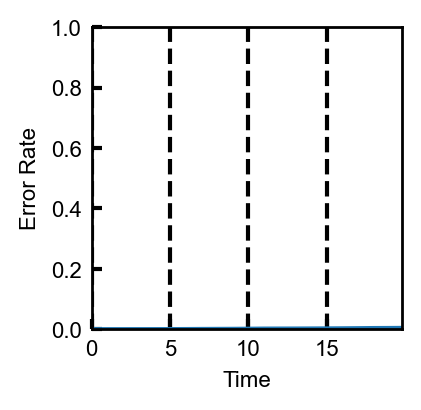

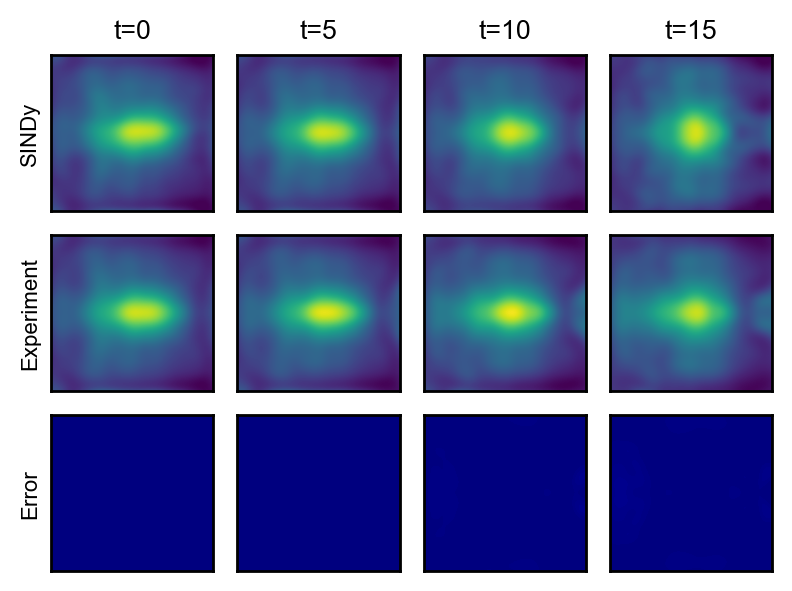

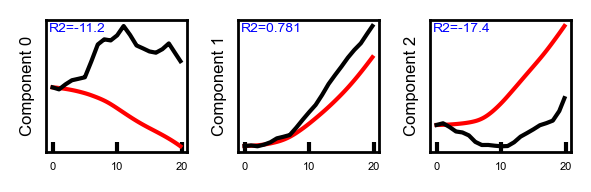

In [8]:
from utils.translation_utils import *

lib_path = 'Public/WT/ECad-GFP'
lib_key = 'c'

plt.rcParams['figure.dpi'] = 200

with h5py.File('Public/raw_dynamics_fitting.h5', 'r') as h5f:
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'raw_SVDPipeline_PMG_CF.pkl'), 'rb'))
    #model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'raw_SVDPipeline.pkl'), 'rb'))

    evr = model['svd'].explained_variance_ratio_
    keep=np.cumsum(evr) <= 0.93
    scaled_evr = evr / np.min(evr[keep]) * keep
    
    info_ovl = dict(
        key=lib_key,
        tmin=0, tmax=15,
        scale_units=True,
        material_derivative=True,
        #component_weight=scaled_evr**2,
        threshold=0,
        alpha=0,#1e0,
        n_candidates_to_drop=0,
        n_models=10,
        n_subset=30,
        overleaf_only=True,
        collect_function=collect_raw_data,
        component_weight=None,
    )
    info_all = dict(
        key=lib_key,
        tmin=-5, tmax=15,
        scale_units=True,
        material_derivative=True,
        threshold=1e-2,
        alpha=1e2,
        n_candidates_to_drop=1,
        n_models=10,
        n_subset=30,
        overleaf_only=False,
        #collect_function=collect_raw_data,
        #component_weight=None,
        component_weight=scaled_evr,
    )
    info = info_all
    sindy = fit_sindy_model(h5f, **info)

    data = h5f['ensemble']
    '''
    Evaluate model
    '''
    tmin, tmax = info['tmin'], info['tmax']
    tmin, tmax = 0, 20
    
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models/raw_SVDPipeline.pkl'), 'rb'))
    evr = model['svd'].explained_variance_ratio_
    
    keep = np.cumsum(evr) <= 1
    tmin = max(tmin, int(np.min(data['fields'][lib_key].attrs['t'])))
    tmax = min(tmax, int(np.max(data['fields'][lib_key].attrs['t'])))
    pred, interp, times = sindy_predict(data, lib_key, sindy, model, keep, tmin=tmin, tmax=tmax)
    plt.rcParams['image.cmap'] = 'viridis'
    plt.rcParams['font.size'] = 8
    sindy_predictions_plot(pred, interp, model, times, keep, data, plot_fn=color_2D)
    decomposed_predictions_plot(pred, interp, model, times, scaled_evr > 0)

## Myosin

[0.569 0.771 0.876 0.914 0.934 0.948 0.956 0.963 0.967 0.971 0.974 0.977
 0.98  0.981 0.983 0.984]
Using only overleaf-allowed terms
Skipping ensemble average from fit!
Adding Material Derivative terms to LHS
Applying train/test split
Using an ensemble optimizer!
D_t m_ij  = -0.007 m_ij + -0.668 {m_ij, E_passive} + 1.072 c {m_ij, E_passive} + 0.007 Static_DV Tr(m_ij) + 0.209 m_ij Tr(m_ij)
PCA Component R2=-0.87454	MSE=0.344385


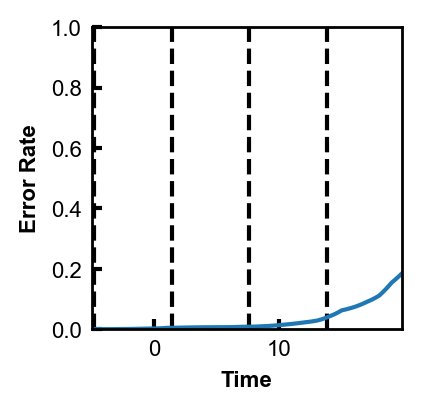

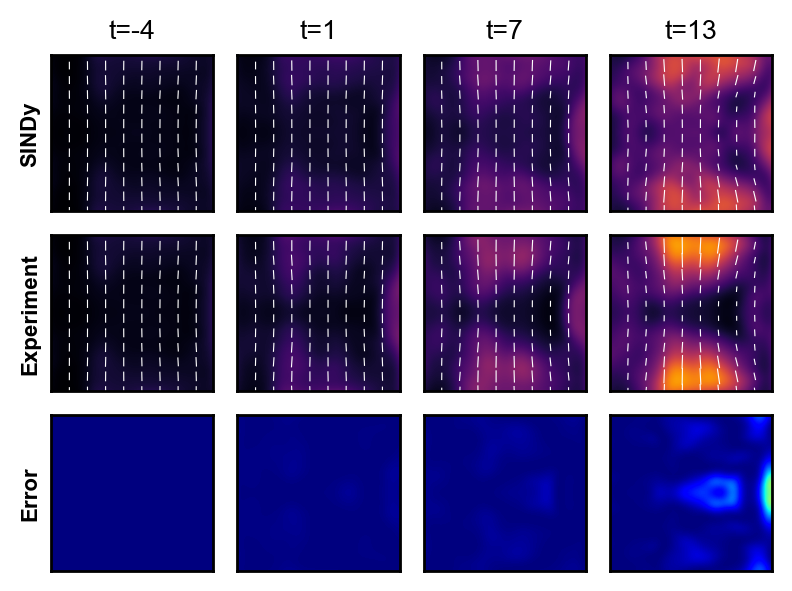

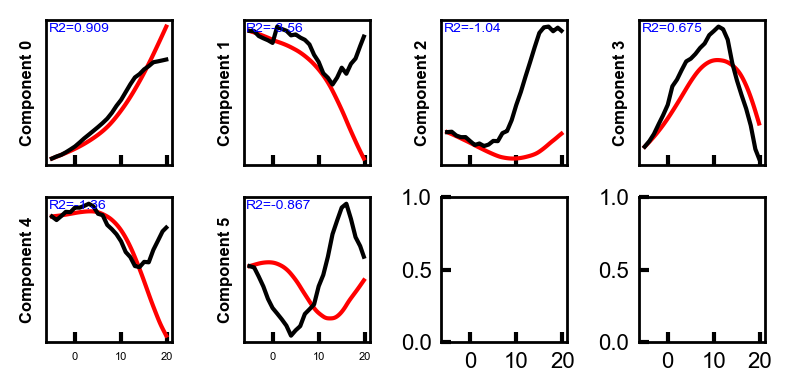

In [255]:
from utils.translation_utils import *

lib_path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP'
lib_key = 'm_ij'
plt.rcParams['figure.dpi'] = 200
np.set_printoptions(precision=3, suppress=True)

with h5py.File('Public/raw_dynamics_fitting.h5', 'r') as h5f:
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'tensor_SVDPipeline.pkl'), 'rb'))
    #model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 'tensor_SVDPipeline_PMG_CF.pkl'), 'rb'))

    evr = model['svd'].explained_variance_ratio_
    print(np.cumsum(evr))
    keep=np.cumsum(evr) <= 0.95
    scaled_evr = evr / np.min(evr[keep]) * keep
    
    info_ovl = dict(
        key=lib_key,
        tmin=-5, tmax=10,
        material_derivative=True,
        keep=keep,
        #component_weight=scaled_evr**2,
        threshold=0,
        alpha=1e-1,
        n_candidates_to_drop=0,
        n_models=10,
        n_subset=1000,
        overleaf_only=True,
        collect_function=collect_raw_data,
        component_weight=None,
    )
    info = info_ovl
    sindy = fit_sindy_model(h5f, **info)

    data = h5f['ensemble']
    #data = h5f['202001280915']
    #data = h5f['202001282000']
    
    '''
    Evaluate model
    '''
    tmin, tmax = info['tmin'], info['tmax']
    tmin, tmax = -5, 20
    
    model = pk.load(open(os.path.join(lib_path, 'decomposition_models/tensor_SVDPipeline.pkl'), 'rb'))
    evr = model['svd'].explained_variance_ratio_
    
    keep = np.cumsum(evr) <= 1
    tmin = max(tmin, int(np.min(data['fields'][lib_key].attrs['t'])))
    tmax = min(tmax, int(np.max(data['fields'][lib_key].attrs['t'])))
    pred, interp, times = sindy_predict(data, lib_key, sindy, model, keep, tmin=tmin, tmax=tmax)
    plt.rcParams['image.cmap'] = 'inferno'
    sindy_predictions_plot(pred, interp, model, times, keep, data)
    decomposed_predictions_plot(pred, interp, model, times, info['keep'])


## Ensembling

In [253]:
%%capture --no-display

from utils.translation_utils import *
from itertools import product

lib_path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP'
lib_key = 'm_ij'
plt.rcParams['figure.dpi'] = 200
np.set_printoptions(precision=3, suppress=True)

model = pk.load(open(os.path.join(lib_path, 'decomposition_models', 
                                  'tensor_SVDPipeline.pkl'), 'rb'))
                                  #'tensor_SVDPipeline_PMG_CF.pkl'), 'rb'))


sindy_results = pd.DataFrame()

evr = model['svd'].explained_variance_ratio_
keep=np.cumsum(evr) <= 0.95
scaled_evr = evr / np.min(evr[keep]) * keep


withold_0 = []
withold_1 = ['E_passive', 'c E_passive', 'c m_ij', 'E_passive Tr(m_ij)', 'c m_ij Tr(E_passive)', 'c E_passive Tr(m_ij)', 'Static_DV', 'c Static_DV', 'c {m_ij, Static_DV}']

withold = withold_0# + withold_1

info = dict(
    key=lib_key,
    tmin=-10, tmax=20,
    material_derivative=True,
    component_weight=scaled_evr,
    n_models=10,
    n_candidates_to_drop=5,
    n_subset=30,
    overleaf_only=False,
    withold=withold
)

alphas = np.geomspace(1e-1, 5e1, 5)
thresholds = np.geomspace(1e-3, 5e-2, 5)
ntrials = 5

with h5py.File('Public/raw_dynamics_fitting.h5', 'r') as h5f:
    '''
    ntrials = 25
    for alpha in alphas:
        for i in range(ntrials):
            info['alpha'] = alpha
            sindy = fit_ssr_model(h5f, **info)
            coef_list = np.array(sindy.optimizer.history_).squeeze()
            score_list = np.array(sindy.optimizer.err_history_).squeeze()
            #SINDy doesn't record error for initial guess
            score_list = np.concatenate([[score_list[0]], score_list]) 
            
            df = pd.DataFrame(coef_list, columns=sindy.feature_names)
            df['score'] = score_list
            sindy_results = sindy_results.append(df, ignore_index=True).fillna(value=0)
    '''
    
    ntrials = 5
    for alpha, threshold in product(alphas, thresholds):
        for i in range(ntrials):
            info['alpha'] = alpha
            info['threshold'] = threshold
            sindy = fit_sindy_model(h5f, **info)
            
            fn = sindy.feature_names
            coef_list = np.array(sindy.coef_list_).squeeze() #n_models x n_coefs
            coef = sindy.coefficients().squeeze()
            reg = np.nan_to_num(coef / np.median(coef_list, axis=0))
            coef_list *= reg

            mses_list = np.array(sindy.mses_list_).squeeze() #n_models x n_cpts
            weighted_mse = np.average(mses_list, axis=-1, weights=scaled_evr) * 1000

            df = pd.DataFrame(coef_list, columns=fn)
            df['score'] = weighted_mse
            sindy_results = sindy_results.append(df, ignore_index=True)
sindy_results

,E_passive,E_passive Tr(m_ij),Static_DV,Static_DV Tr(m_ij),c E_passive,c E_passive Tr(m_ij),c Static_DV,c Static_DV Tr(m_ij),c m_ij,c m_ij Tr(E_passive),c m_ij Tr(m_ij),"c {m_ij, E_passive}","c {m_ij, Static_DV}",m_ij,m_ij Tr(E_passive),m_ij Tr(m_ij),"{m_ij, E_passive}","{m_ij, Static_DV}",score
0,0.0,0.0,0.0,-0.000000,0.247200,1.999230,0.0,-0.000000,0.405655,0.0,0.0,0.0,-0.000000,-1.139067,2.081798,0.080708,-6.687320,0.0,17.726581
1,0.0,-0.0,0.0,-44.788103,0.000000,-0.278977,-0.0,1.117193,0.050804,0.0,0.0,0.0,0.009167,0.441526,0.000000,0.066946,3.912008,0.0,17.987256
2,0.0,0.0,-0.0,-33.643506,0.290012,3.964221,0.0,-45.219399,1.018247,0.0,0.0,-0.0,-0.000000,-2.143721,4.195445,-0.000000,-17.189691,0.0,14.893169
3,-0.0,0.0,0.0,-0.000000,0.108166,2.969481,-0.0,-0.735293,0.413448,0.0,0.0,0.0,-0.010317,0.598209,0.057132,0.089583,6.409788,0.0,19.342082
4,0.0,0.0,0.0,0.928976,0.181193,1.588931,0.0,-0.000000,0.125582,0.0,-0.0,0.0,-0.000000,0.000000,-0.174721,-0.000000,0.000000,0.0,20.094518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,11.561049
1246,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,11.561049
1247,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,11.561049
1248,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,11.561049


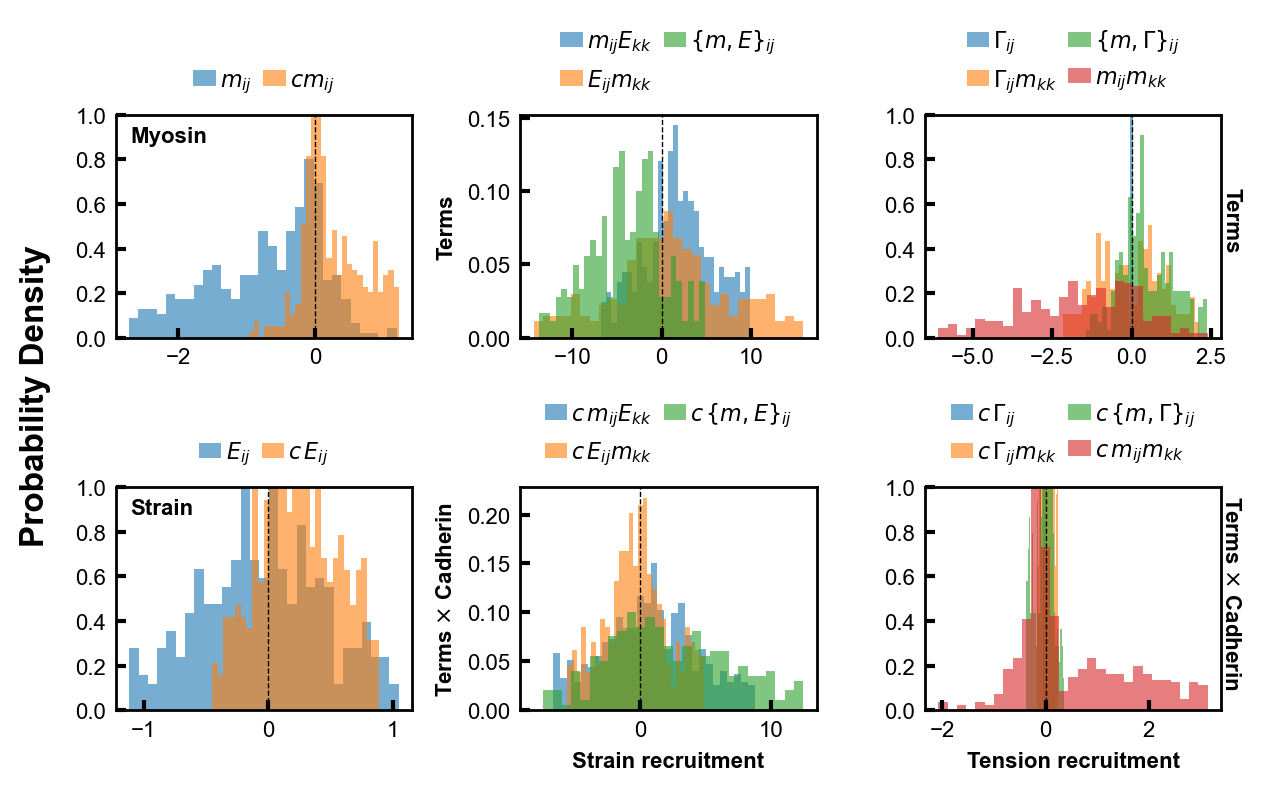

In [247]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['legend.framealpha'] = 0
plt.rcParams['legend.columnspacing'] = .5
plt.rcParams['legend.handletextpad'] = 0.2
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelweight'] = 'bold'

from scipy.stats import iqr
def scatter_terms(ax, terms, labels=None, df=sindy_results, title=''):
    if labels is None: labels = terms
    ylim = 0.
    for i, term in enumerate(terms):
        if not term in df.columns:
            print('Not found in dataframe: ', term)
            ax.plot([0], [0])
            continue
        coef = df[term].values
        coef = coef[np.abs(coef) > 0]
        coef = coef
        med = np.median(coef)
        sep = iqr(coef)
        N = 30
        bins = np.linspace(med-sep, med+sep, N)
        
        ymax = .5 / sep
        ylim = max(ylim, ymax)
        
        n, _, p = ax.hist(coef, label=labels[i], bins=bins, density=True, alpha=0.6, stacked=True)
        #ax.axvline(med, color=p[0].get_facecolor()[:-1], lw=1, linestyle='--')
    ax.legend(ncol=2, bbox_to_anchor=[0.5, 1], loc='lower center')
    ax.axvline(0, color='black', lw=0.5, linestyle='--')
    ax.set_ylim([0, min(1, np.max(ax.get_ylim()))])
    ax.text(0.05, 0.95, title, fontweight='bold', va='top', ha='left', transform=ax.transAxes)

fig, ax = plt.subplots(2, 3, constrained_layout=True, sharey=False)
    
terms = ['m_ij', 'c m_ij']
#sindy_results['m_ij'] *= -1
scatter_terms(ax[0, 0], terms, ['$m_{ij}$', '$c m_{ij}$'], title='Myosin')

terms = ['E_passive', 'c E_passive']
scatter_terms(ax[1, 0], terms, ['$E_{ij}$', '$c\,E_{ij}$'], title='Strain')

terms = ['m_ij Tr(E_passive)', 'E_passive Tr(m_ij)', '{m_ij, E_passive}']
scatter_terms(ax[0, 1], terms, ['$m_{ij} E_{kk}$', '$E_{ij} m_{kk}$', '$\{m, E\}_{ij}$'])

terms = ['c m_ij Tr(E_passive)', 'c E_passive Tr(m_ij)', 'c {m_ij, E_passive}']
scatter_terms(ax[1, 1], terms, ['$c\,m_{ij} E_{kk}$', '$c\,E_{ij} m_{kk}$', '$c\,\{m, E\}_{ij}$'])


terms = ['Static_DV', 'Static_DV Tr(m_ij)', '{m_ij, Static_DV}', 'm_ij Tr(m_ij)']
scatter_terms(ax[0, 2], terms, ['$\Gamma_{ij}$', '$\Gamma_{ij} m_{kk} $', '$\{m, \Gamma\}_{ij}$', '$m_{ij} m_{kk}$'])

terms = ['c Static_DV', 'c Static_DV Tr(m_ij)', 'c {m_ij, Static_DV}', 'c m_ij Tr(m_ij)']
scatter_terms(ax[1, 2], terms, ['$c\,\Gamma_{ij}$', '$c\,\Gamma_{ij} m_{kk} $', '$c\,\{m, \Gamma\}_{ij}$', '$c\,m_{ij} m_{kk}$'])


ax[1, 1].set_xlabel('Strain recruitment')
ax[1, 2].set_xlabel('Tension recruitment')
ax[0, 1].set_ylabel('Terms')
ax[1, 1].set_ylabel('Terms $\\times$ Cadherin')

fig.text(1, 0.53, 'Terms', rotation=-90, 
         va='center', ha='left',
         fontweight='bold', transform=ax[0, -1].transAxes)
fig.text(1, 0.53, 'Terms $\\times$ Cadherin', rotation=-90, 
         va='center', ha='left',
         fontweight='bold', transform=ax[1, -1].transAxes)

fig.text(0, 0.5, 'Probability Density', rotation=90, fontsize=12, fontweight='bold', va='center', ha='right')

plt.tight_layout()